In [66]:
import os
import random
import numpy as np 
from matplotlib import pyplot as plt 
import cv2 

In [67]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Layer, MaxPooling2D, Input
import tensorflow as tf   

In [68]:
gpu = tf.config.experimental.list_physical_devices("GPU")
print(gpu)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [69]:
#tf.config.experimental.set_memory_growth(gpu,True)

In [70]:
#https://vis-www.cs.umass.edu/lfw/#deepfunnel-anchor
# !tar -xf lfw.tgz

In [71]:
# for dis in os.listdir('lfw'):
#     for imgs in os.listdir(os.path.join('lfw',dis)):
#         old = os.path.join('lfw',dis,imgs)
#         new = os.path.join("data","negative",imgs)
#         os.replace(old,new)

In [72]:
# dis = os.listdir('lfw')
# print(dis)

In [73]:
# file = os.listdir(os.path.join('lfw',dis[0]))
# print(file)

In [74]:
# old = os.path.join('lfw',dis[0],file[0])
# print(old)

In [75]:
# new = os.path.join('data','negative',file[0])
# print(new)

In [76]:
# os.replace(old,new)

In [77]:
#capture Data is pos.ipynb file in data folder directly 

In [78]:
# to give path as single variable in dataset loader 
anchor_path = os.path.join('data','anchor')
positive_path = os.path.join('data','positive')
negative_path = os.path.join('data','negative')
print(anchor_path,positive_path,negative_path)

data/anchor data/positive data/negative


In [79]:
anchor = tf.data.Dataset.list_files(anchor_path+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(negative_path+'/*.jpg').take(300)
positve = tf.data.Dataset.list_files(positive_path+'/*.jpg').take(300)

In [80]:
# dir_test = negative.as_numpy_iterator()
# dir_test.next()

In [81]:
def preprocess(path):
    load_img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(load_img)
    img = tf.image.resize(img,(100,100))
    img = img/255.0
    return img     

In [82]:
# #testing
# load_img = tf.io.read_file("/mnt/d/Face/data/anchor/7a1d847a-993c-11ef-9bdd-e0c264bb8b6c.jpg")
# img = tf.io.decode_jpeg(load_img)
# np.array(img)

In [83]:
positves = tf.data.Dataset.zip((anchor,positve,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(negative)))))
data = positves.concatenate(negatives)

In [84]:
def multi_preprocess(input_img, validation_img, label):
    return preprocess(input_img) , preprocess(validation_img) , label

In [85]:
# #example 
# ex = data.as_numpy_iterator()
# ex=ex.next()

In [86]:
# ex_output = multi_preprocess(*ex)

In [87]:
# plt.imshow(ex_output[0])


In [88]:
# plt.imshow(ex_output[1])

In [89]:
# ex_output[2]

In [90]:
data = data.map(multi_preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)

In [91]:
# a = data.as_numpy_iterator()
# a = a.next()

In [92]:
# a[2]

In [93]:
# plt.imshow(a[0])

In [94]:
# plt.imshow(a[1])

In [95]:
train_data = data.take(round(len(data)*7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [96]:
# f = train_data.as_numpy_iterator()
# f = f.next()

In [97]:
# len(f[0])

In [98]:
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(16)

In [99]:
# x = test_data.as_numpy_iterator()
# x = x.next()

In [100]:
# len(x[0])

In [101]:
def embedding_layer():
    input_layer = Input(shape=(100,100,3), name="Input Image")

    con1 = Conv2D(64,(10,10),activation='relu')(input_layer)
    max1 = MaxPooling2D(64,(2,2),padding='same')(con1)

    con2 = Conv2D(128,(7,7),activation='relu')(max1)
    max2 = MaxPooling2D(64,(2,2),padding='same')(con2)

    con3 = Conv2D(128,(4,4),activation='relu')(max2)
    max3 = MaxPooling2D(64,(2,2),padding='same')(con3)

    con4 = Conv2D(256,(4,4),activation='relu')(max3)

    flat = Flatten()(con4)
    dense_layer = Dense(4096,activation='sigmoid')(flat)

    return Model(inputs =[input_layer] ,outputs = dense_layer ,name="embedding_layer")



In [102]:
model_features = embedding_layer()

In [103]:
model_features.summary() 

Model: "embedding_layer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input Image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [104]:
class L1_Distance_layer(Layer):
    def __init__(self,**kwargs):
        super().__init__()

    def call(self, input_emberdding , val_emberdding):
        return tf.math.abs(input_emberdding - val_emberdding)

In [105]:
def make_siamese_model():
    input_img_siamese = Input(shape=(100,100,3), name="input_img_siamese")
    val_img_siamese = Input(shape=(100,100,3), name='val_img_siamese')

    a = model_features(input_img_siamese)
    b = model_features(val_img_siamese)



    L1 = L1_Distance_layer()
    distance = L1(a,b)

    output_layer = Dense(1,activation='sigmoid')(distance)

    return Model(inputs = [input_img_siamese,val_img_siamese], outputs = output_layer , name='siamese_model')


In [106]:
siamese_model = make_siamese_model()

In [107]:
siamese_model.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img_siamese   │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_img_siamese     │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 4096)      │ 38,960,448 │ input_img_siames… │
│ (Functional)        │                   │            │ val_img_siamese[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1__distance_layer… │ (None, 4096)      │          0 │ embedding_layer[… │
│ (L1_Distance_layer) │                   │            │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1__distance_lay… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [108]:
tf.keras.utils.plot_model(siamese_model,"siamese_model.png")

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [109]:
binary_cross_loss = tf.keras.losses.BinaryCrossentropy()

In [110]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [111]:

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [112]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = [batch[0],batch[1]]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model( [batch[0],batch[1]] , training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [113]:
from tensorflow.keras.metrics import Precision, Recall

In [114]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict([batch[0],batch[1]])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [115]:
EPOCHS = 10

In [116]:
train(train_data, EPOCHS)


 Epoch 1/10
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━

2025-01-15 19:37:02.420989: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/stepe
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/stepste
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/steptep
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/stepte
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s

2025-01-15 19:48:06.938627: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [117]:
#EVALUATE

from tensorflow.keras.metrics import Precision, Recall


In [118]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [119]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [120]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0]

In [121]:
y_true

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [122]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [123]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [124]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1.0 1.0


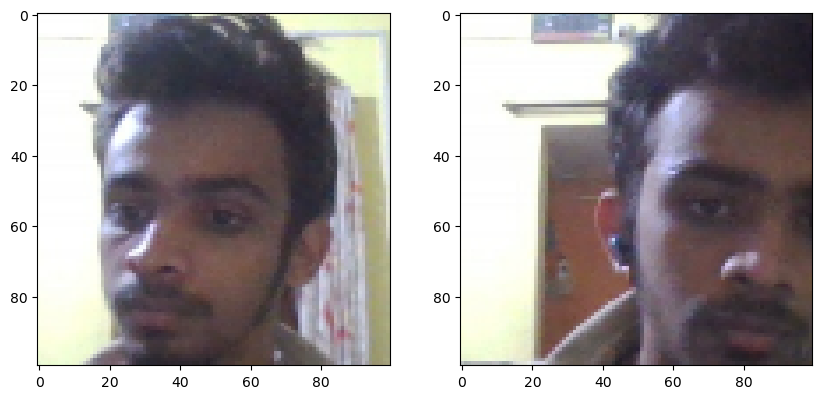

In [125]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [126]:
siamese_model.save('siamesemodelv2.h5')

In [127]:
L1_Distance_layer

__main__.L1_Distance_layer

In [128]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1_Distance_layer':L1_Distance_layer, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [129]:
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


array([[9.9925441e-01],
       [5.7025158e-08],
       [1.0000000e+00],
       [4.5631873e-07]], dtype=float32)

In [130]:
siamese_model.summary()

Model: "siamese_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img_siamese   │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ val_img_siamese     │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_layer     │ (None, 4096)      │ 38,960,448 │ input_img_siames… │
│ (Functional)        │                   │            │ val_img_siamese[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1__distance_layer… │ (None, 4096)      │          0 │ embedding_layer[… │
│ (L1_Distance_layer) │                   │            │ embedding_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1__distance_lay… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)